## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
data = pd.read_csv('/home/anna/SF/data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [5]:
data_gr =data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
display(data_gr.head(2))
display(data_gr.tail(2))

,date,group,users_count,purchase,price
0,2021-01-02,A,2894,362,29720000
1,2021-01-02,B,2889,348,29920000


,date,group,users_count,purchase,price
44,2021-01-24,A,3811,451,33700000
45,2021-01-24,B,3727,449,39280000


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
print('Общее количество посещений группы А', data_gr[data_gr['group'] == 'A']['users_count'].sum())
print('Общее количество посещений группы B', data_gr[data_gr['group'] == 'B']['users_count'].sum())

Общее количество посещений группы А 147202
Общее количество посещений группы B 147276


In [7]:
print('Общее количество покупок группы А', data_gr[data_gr['group'] == 'A']['purchase'].sum())
print('Общее количество покупок группы B', data_gr[data_gr['group'] == 'B']['purchase'].sum())

Общее количество покупок группы А 17723
Общее количество покупок группы B 17514


In [8]:
print('Общая сумма покупок группы А', data_gr[data_gr['group'] == 'A']['price'].sum()/1e6)
print('Общая сумма покупок группы B', data_gr[data_gr['group'] == 'B']['price'].sum()/1e6)

Общая сумма покупок группы А 1436.26
Общая сумма покупок группы B 1554.1


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [9]:
unique_id_A = set(data[data['group'] == 'A']['user_id'])
unique_id_B = set(data[data['group'] == 'B']['user_id'])
user_interseсtion = unique_id_A.intersection(unique_id_B)
len(user_interseсtion)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [16]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_interseсtion)]

In [17]:
updated_data.tail()

,user_id,date,group,purchase,price
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0
294477,715931,2021-01-16,B,0,0


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

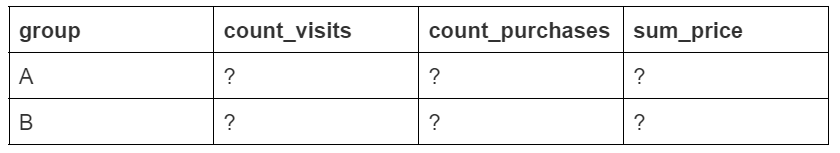
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [12]:
updated_data_grupped =updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
updated_data_grupped

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

ваши выводы здесь

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [13]:
updated_data_grupped['conversion'] = round(100*(updated_data_grupped['count_purchases']/updated_data_grupped['count_visits']), 2)
updated_data_grupped['mean_check'] = updated_data_grupped['sum_price']/updated_data_grupped['count_purchases']
updated_data_grupped

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.228055
1,B,145381,17290,1533010000,11.89,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

ваши выводы здесь

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [44]:
updated_data.head(2)

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0


In [151]:
updated_data_tour_gr = updated_data[updated_data['price'] != 0].groupby(['group', 'price']).agg({
    'purchase':'sum'}).reset_index().rename(columns={'user_id': 'users_count'})
# updated_data_tour_gr.drop(, axis = 1, inplace= True)
updated_data_tour_gr

,group,price,purchase
0,A,10000,5182
1,A,60000,5271
2,A,100000,1832
3,A,150000,3478
4,A,200000,1724
5,B,10000,5201
6,B,60000,1730
7,B,100000,5227
8,B,150000,3438
9,B,200000,1694


In [157]:
pivot_tab = updated_data_tour_gr.pivot_table(values='purchase', index='price', columns='group')
pivot_tab

group,A,B
price,,
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

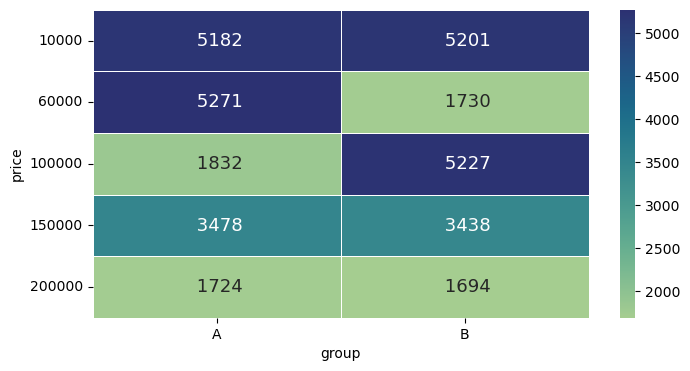

In [175]:
fig, ax = plt.subplots(figsize = (8,4))
sns.heatmap(pivot_tab, annot=True, fmt=" d", annot_kws={"size":13}, cmap="crest", linewidths=.5);
ax.set_yticklabels(labels = pivot_tab.index, rotation=0);

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

    из графика тепловой карты четко видно что в группе А было больше продано более дешевых туров за 60 000 руб 
    в то время как в группе В  более дорогих за 100 000 руб
    остальные показатели довольно близки

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [45]:
cumm_data_grupped =updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
cumm_data_grupped['conversed'] = round(100*cumm_data_grupped['count_purchases']/cumm_data_grupped['count_visits'], 2)
cumm_data_grupped['mean_check'] = round(cumm_data_grupped['sum_price']/cumm_data_grupped['count_purchases'], 0)
cumm_data_grupped.head(8)

,date,group,count_visits,count_purchases,sum_price,conversed,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0
5,2021-01-04,B,6536,764,68030000,11.69,89045.0
6,2021-01-05,A,6433,790,64550000,12.28,81709.0
7,2021-01-05,B,6511,749,63550000,11.50,84846.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [48]:
cumm_data_grupped_a = cumm_data_grupped[cumm_data_grupped['group'] == 'A'].copy()
cumm_data_grupped_b = cumm_data_grupped[cumm_data_grupped['group'] == 'B'].copy()

In [49]:
cumm_data_grupped_a.head()

,date,group,count_visits,count_purchases,sum_price,conversed,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0
6,2021-01-05,A,6433,790,64550000,12.28,81709.0
8,2021-01-06,A,6606,764,63410000,11.57,82997.0


In [123]:
# вычисляем кумулятивную сумму количества посетителей
cumm_data_grupped_a['cum_users_count'] = cumm_data_grupped_a['count_visits'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
cumm_data_grupped_a['cum_count_purchases'] = cumm_data_grupped_a['count_purchases'].cumsum()
# вычисляем кумулятивную конверсию
cumm_data_grupped_a['cum_sum_price'] = cumm_data_grupped_a['sum_price'].cumsum()
cumm_data_grupped_a['cum_conversed'] = 100* cumm_data_grupped_a['cum_count_purchases']/cumm_data_grupped_a['cum_users_count']
cumm_data_grupped_a['cum_mean_check'] = round(cumm_data_grupped_a['cum_sum_price']/cumm_data_grupped_a['cum_count_purchases'], 0)
display(cumm_data_grupped_a.head())

,date,group,count_visits,count_purchases,sum_price,conversed,mean_check,cum_users_count,cum_count_purchases,cum_sum_price,cum_conversed,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.578837,81922.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.714286,82575.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.900599,81668.0
6,2021-01-05,A,6433,790,64550000,12.28,81709.0,22449,2696,220210000,12.009444,81680.0
8,2021-01-06,A,6606,764,63410000,11.57,82997.0,29055,3460,283620000,11.908449,81971.0


In [124]:
# вычисляем кумулятивную сумму количества посетителей
cumm_data_grupped_b['cum_users_count'] = cumm_data_grupped_b['count_visits'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
cumm_data_grupped_b['cum_count_purchases'] = cumm_data_grupped_b['count_purchases'].cumsum()
# вычисляем кумулятивную конверсию
cumm_data_grupped_b['cum_sum_price'] = cumm_data_grupped_b['sum_price'].cumsum()
cumm_data_grupped_b['cum_conversed'] = 100* cumm_data_grupped_b['cum_count_purchases']/cumm_data_grupped_b['cum_users_count']
cumm_data_grupped_b['cum_mean_check'] = round(cumm_data_grupped_b['cum_sum_price']/cumm_data_grupped_b['cum_count_purchases'], 0)
display(cumm_data_grupped_b.head())

,date,group,count_visits,count_purchases,sum_price,conversed,mean_check,cum_users_count,cum_count_purchases,cum_sum_price,cum_conversed,cum_mean_check
1,2021-01-02,B,2861,345,29660000,12.06,85971.0,2861,345,29660000,12.058721,85971.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0,9480,1099,95620000,11.592827,87006.0
5,2021-01-04,B,6536,764,68030000,11.69,89045.0,16016,1863,163650000,11.632118,87842.0
7,2021-01-05,B,6511,749,63550000,11.50,84846.0,22527,2612,227200000,11.594975,86983.0
9,2021-01-06,B,6751,838,75020000,12.41,89523.0,29278,3450,302220000,11.783592,87600.0


In [52]:
cumm_data_grupped_b[cumm_data_grupped_b['date'] == '2021-01-20']

,date,group,count_visits,count_purchases,sum_price,conversed,mean_check,cum_users_count,cum_count_purchases,cum_sum_price,cum_conversed,cum_mean_check
37,2021-01-20,B,6685,790,69250000,11.82,87658.0,121857,14496,1286900000,11.9,88776.0


In [53]:
cumm_data_grupped_a[cumm_data_grupped_a['date'] == '2021-01-12']

,date,group,count_visits,count_purchases,sum_price,conversed,mean_check,cum_users_count,cum_count_purchases,cum_sum_price,cum_conversed,cum_mean_check
20,2021-01-12,A,6540,795,68460000,12.16,86113.0,68852,8198,668070000,11.91,81492.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

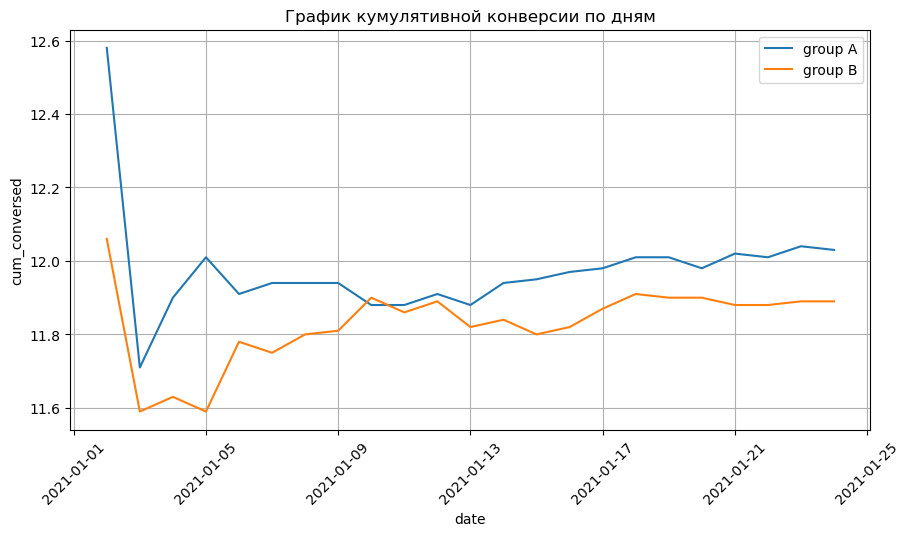

In [66]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversed', data= cumm_data_grupped_a, ax=ax, label='group A')
#
sns.lineplot(x='date', y='cum_conversed', data= cumm_data_grupped_b, ax=ax, label='group B')
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
ax.legend()
# задаём отображение сетки
ax.grid(True);

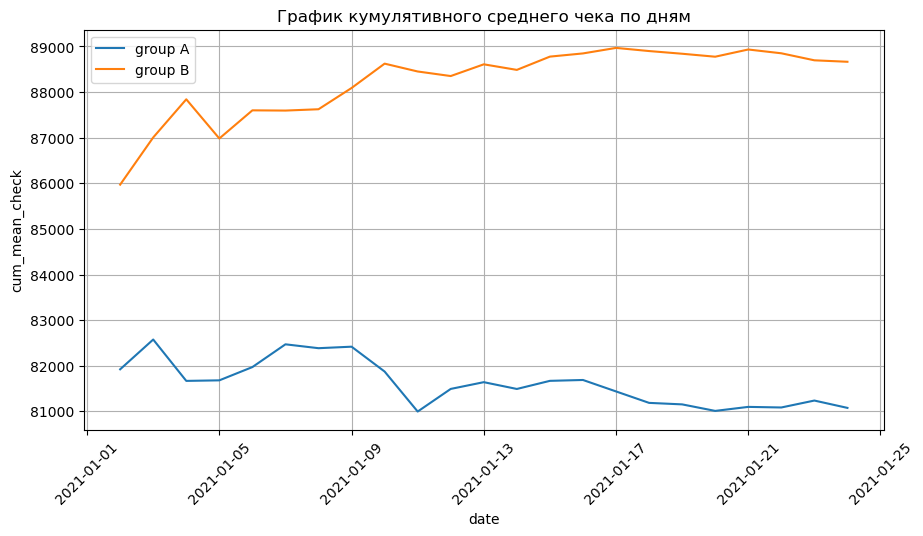

In [80]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data= cumm_data_grupped_a, ax=ax, label='group A')
#
sns.lineplot(x='date', y='cum_mean_check', data= cumm_data_grupped_b, ax=ax, label='group B')
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

    Из графиков видно что показатели стабилизируются
    на графики кумулятивной конверсии по дням все еще видны "заломы"/ небольшие скачки, по этому я бы рекомендовала продолжить эксперимен до полной стабилизации метрик, тем не менее видна тенденция - кумулятивная конверсия группы "А" немного больше кумулятивной конверсии группы "В"
    На графике кумулятивного среднего чека явно видно разницу в показателях средний чек группы "В" значительно выше среднего чека в группе "А"

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [69]:
cumm_data_grupped_b.tail()

,date,group,count_visits,count_purchases,sum_price,conversed,mean_check,cum_users_count,cum_count_purchases,cum_sum_price,cum_conversed,cum_mean_check
37,2021-01-20,B,6685,790,69250000,11.82,87658.0,121857,14496,1286900000,11.90,88776.0
39,2021-01-21,B,6555,760,69870000,11.59,91934.0,128412,15256,1356770000,11.88,88934.0
41,2021-01-22,B,6659,787,68660000,11.82,87243.0,135071,16043,1425430000,11.88,88851.0
43,2021-01-23,B,6633,805,68930000,12.14,85627.0,141704,16848,1494360000,11.89,88697.0
45,2021-01-24,B,3677,442,38650000,12.02,87443.0,145381,17290,1533010000,11.89,88665.0


    для того чтобы выбрать тест на доверительные интервалы сначала проверим как распределены данные

In [71]:
from scipy.stats import shapiro
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05
_, p = shapiro(cumm_data_grupped_a['conversed'])
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.295
Данные распределены нормально


In [72]:
from scipy.stats import shapiro
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05
_, p = shapiro(cumm_data_grupped_b['conversed'])
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.911
Данные распределены нормально


    в обоих выборках данные распределены нормально
    мы хотим расчитать доверительные интервалы для конверсии (переменная количественная)
    сравниваем 2 группы, объектов в выборке более 300
    по этому буду рассчитывать доверительные интервалы с помощью z-теста

In [78]:
from statsmodels.stats.proportion import proportions_ztest
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=[list(cumm_data_grupped_a['cum_count_purchases'])[-1], list(cumm_data_grupped_b['cum_count_purchases'])[-1]], #число "успехов"
    nobs=[list(cumm_data_grupped_a['cum_users_count'])[-1], list(cumm_data_grupped_b['cum_users_count'])[-1]], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


    c помощью z-теста удалось понять что разница в конверсиях групп А и В незначительная
    и мы принимаем гипотезу что конверсии в группах А и В равны

Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [81]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    print(eps)
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [131]:
conf_interval_a = proportions_conf_interval(
n=list(cumm_data_grupped_a['cum_users_count'])[-1], # размер выборки
x_p=list(cumm_data_grupped_a['cum_conversed'])[-1]/100 # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=list(cumm_data_grupped_b['cum_users_count'])[-1], # размер выборки
x_p=list(cumm_data_grupped_b['cum_conversed'])[-1]/100 # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [105]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [106]:
# размеры выборок групп А и B
n = [cumm_data_grupped_a['count_visits'].sum(), cumm_data_grupped_b['count_visits'].sum()]
# выборочная пропорция групп A и B
xp = [cumm_data_grupped_a['conversed'].mean()/100, cumm_data_grupped_b['conversed'].mean()/100]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

    Итак, можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.87 % до 12.2 %, а конверсия группы B лежит в интервале от 11.73 % до 12.06 %.
    Доверительный интервал для разности конверсий: (-0.38, 0.09)
    Левая граница доверительного интервала отрицательная, а правая — положительная. То есть истинная разница в конверсии может быть как положительной, так и отрицательной. Это будет значить, что варианты А и B равнозначны по метрике конверсии. 

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [132]:
cumm_data_grupped_a.head(1)

,date,group,count_visits,count_purchases,sum_price,conversed,mean_check,cum_users_count,cum_count_purchases,cum_sum_price,cum_conversed,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.578837,81922.0


In [133]:
# проверим данные на нормальность рапределения
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05
_, p = shapiro(cumm_data_grupped_a['mean_check'])
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.253
Данные распределены нормально


In [134]:
_, p = shapiro(cumm_data_grupped_b['mean_check'])
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.094
Данные распределены нормально


    данные о среднем чеке в обоих группах распределены нормально

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

   данные распределены нормально в обоих выборках

   переменная количественная

   сравниваем 2 группы

   объектов в выборке менее 30
   
   будем применять Т-тест


In [135]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Ежедненвые средние чеки в группах А и B равны'
H1 = 'Ежедненвый средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=cumm_data_grupped_a['mean_check'],
    b=cumm_data_grupped_b['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедненвые средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедненвый средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

    с помощью t- теста удалось подтвердить выводы которые я сделала после построения графика
    Ежедневный средний чек в группе А меньше чем в группе В

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [141]:
cumm_data_grupped_a['mean_check'].std()

3096.388506406891

In [142]:
from scipy.stats import t
n = len(list(cumm_data_grupped_a['mean_check'])) # размер выборки
k = n - 1 # число степеней свободы
x_mean = cumm_data_grupped_a['mean_check'].mean() # выборочное среднее
x_std = cumm_data_grupped_a['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (79630, 82308)


In [143]:
n = len(list(cumm_data_grupped_b['mean_check'])) # размер выборки
k = n - 1 # число степеней свободы
x_mean = cumm_data_grupped_b['mean_check'].mean() # выборочное среднее
x_std = cumm_data_grupped_b['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

    Доверительный интервал среднего чека для группы А: (79630, 82308), для группы В: (87626, 89526)
    можно наблюдать существенную разницу между показателями двух групп
    между группами нет пересечения доверительного интервала

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

    Не смотря на то что в конверсии не было существенной разницы, однако мы видим что средний чек группы В значительно выше среднего чека группы А
    Туры проданные с новой версией сайта по количество оказались меньше, а по общей сумме больше.
    Мы видим что новая версия сайта продает более дорогие туры, что выгодно для фирмы
    за время действия теста в группе В было продано туров на 115 млн. рублей больше чем в группе А

    из чего можно сделать вывод что целесообразно внедрить новую модель на постоянной основе